<a href="https://colab.research.google.com/github/sandra-forro/stat-project/blob/main/interactive_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import ipywidgets
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from yellowbrick.datasets import load_concrete
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_curve
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import shap
from shap import TreeExplainer

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
url = 'https://raw.githubusercontent.com/sandra-forro/stat-project/main/data/predictive_maintenance.csv'
df = pd.read_csv(url)

# Visualizing

In [7]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [8]:
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [9]:
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("[", "")
df.columns = df.columns.str.replace("]", "")

In [10]:
df.describe()

,UDI,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [11]:
all_failures = df[df['Failure_Type'] != 'No Failure'] # necessary for visualization without the No Failure Class

In [12]:
variables = ['Air_temperature_K',
       'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm',
       'Tool_wear_min','Failure_Type']

### Class Seperation Check

In [13]:
def plot3d(x, y, z, color, size):
    fig = px.scatter_3d(all_failures, x=x, y=y, z=z,
              color=color, size=size, size_max=25, opacity=0.65, height=700, 
                    title="Seperation of Classes")
    
    return fig

In [ ]:
!pip install ipywidgets==7.7.1

In [15]:
from google.colab import output
output.enable_custom_widget_manager()

In [16]:
ipywidgets.interact(plot3d, x=variables[:-1], 
                    y = variables[:-1],
                    z = variables[:-1],
                    color=variables,
                   size = variables)

interactive(children=(Dropdown(description='x', options=('Air_temperature_K', 'Process_temperature_K', 'Rotati…

<function __main__.plot3d(x, y, z, color, size)>

### Failure by Type Category (L,M,H)

In [17]:
def box(y):
    fig = px.box(df, x="Failure_Type", y=y, color="Type", points='suspectedoutliers', category_orders={'Type': ['L', 'M', 'H']}, width=1000,
                hover_data=['UDI'])
    fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
    return fig 

In [18]:
ipywidgets.interact(box, y=variables[:-1])

interactive(children=(Dropdown(description='y', options=('Air_temperature_K', 'Process_temperature_K', 'Rotati…

<function __main__.box(y)>

In [19]:
all_failures.groupby('Type')['Failure_Type'].count()

Type
H     24
L    243
M     81
Name: Failure_Type, dtype: int64

### Distribution, Correlation, Collinearity & Dummification

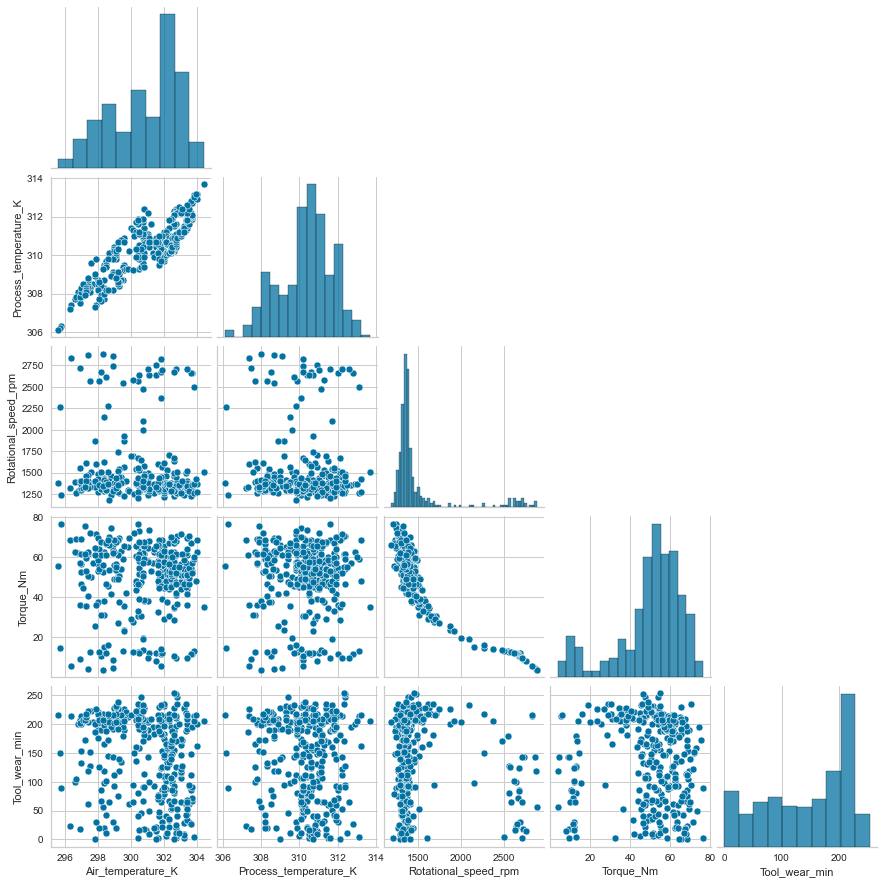

In [ ]:
sns.pairplot(all_failures[variables],corner=True)

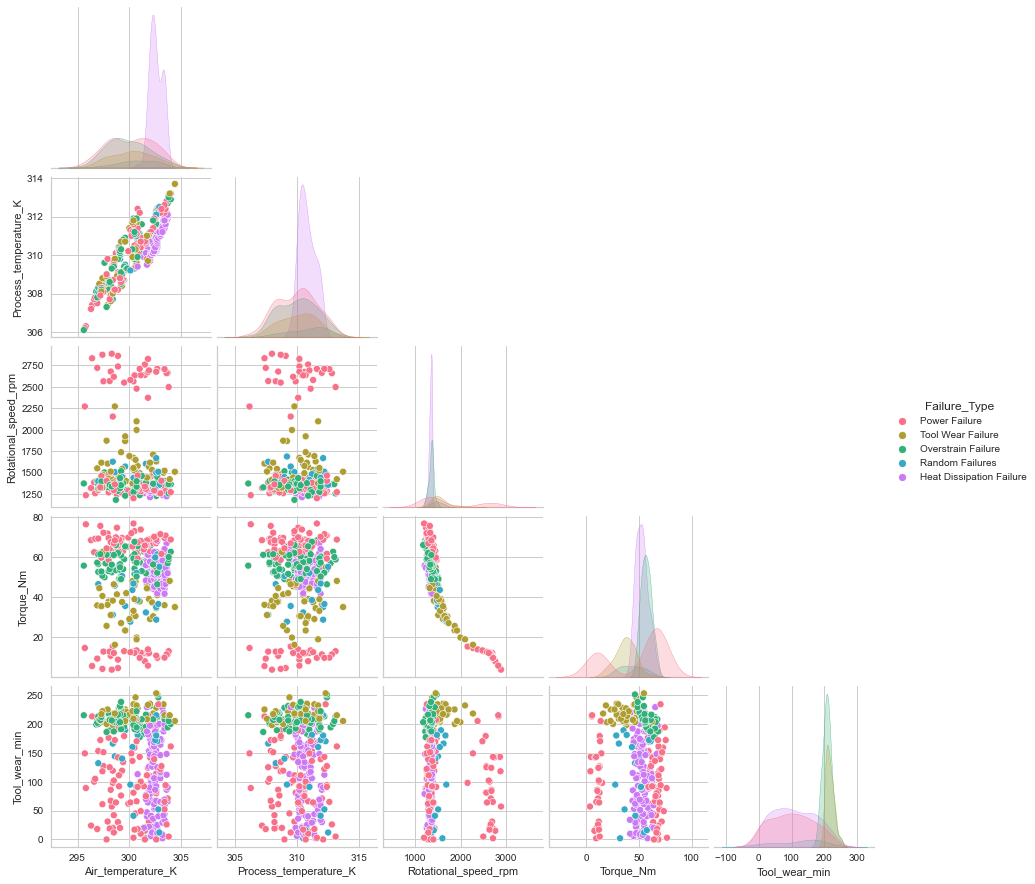

In [ ]:
sns.pairplot(all_failures[variables], hue="Failure_Type", palette='husl', corner=True)

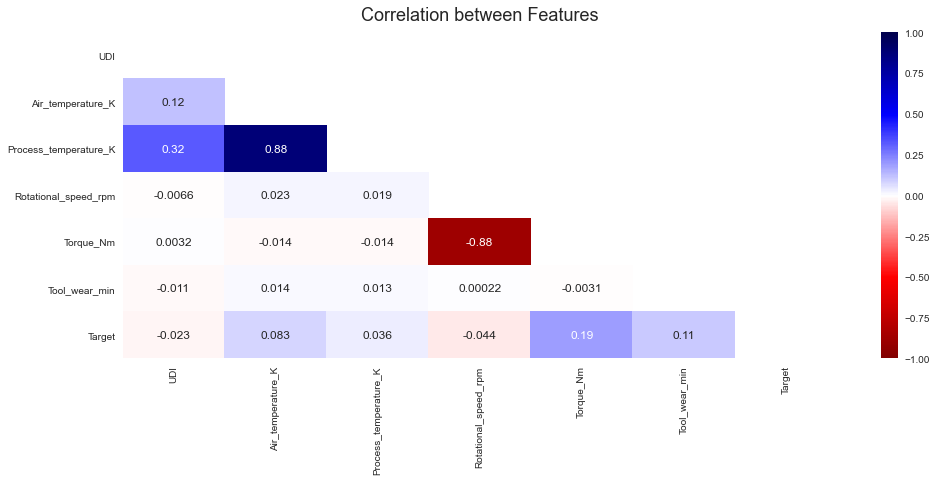

In [ ]:
plt.figure(figsize=(16, 6))
matrix = np.triu(df.corr())
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=plt.get_cmap('seismic').reversed(), mask=matrix)
heatmap.set_title('Correlation between Features', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
#plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [ ]:
LE = LabelEncoder()
df['code'] = LE.fit_transform(df['Failure_Type'])

In [ ]:
le_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
le_name_mapping

{'Heat Dissipation Failure': 0,
 'No Failure': 1,
 'Overstrain Failure': 2,
 'Power Failure': 3,
 'Random Failures': 4,
 'Tool Wear Failure': 5}

In [ ]:
le_name_mapping['Heat Dissipation Failure']=1
le_name_mapping['No Failure']=0

In [ ]:
le_name_mapping

{'Heat Dissipation Failure': 1,
 'No Failure': 0,
 'Overstrain Failure': 2,
 'Power Failure': 3,
 'Random Failures': 4,
 'Tool Wear Failure': 5}

In [ ]:
df['code'] = df['Failure_Type'].map(le_name_mapping)

In [ ]:
df.groupby('Failure_Type')['code'].min()

Failure_Type
Heat Dissipation Failure    1
No Failure                  0
Overstrain Failure          2
Power Failure               3
Random Failures             4
Tool Wear Failure           5
Name: code, dtype: int64

In [ ]:
dummies = pd.get_dummies(df.iloc[:,[2]])

In [ ]:
df_dummified = pd.concat([df, dummies], axis=1)

In [ ]:
features = df_dummified.iloc[:,[3,4,5,6,7, 12, 13, 13]]

In [ ]:
features = "+".join(features.columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('Failure_Type ~' + features, df_dummified, return_type='dataframe')

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [ ]:
vif

,VIF Factor,features
0,48953.289754,Intercept
1,4.304971,Air_temperature_K
2,4.302882,Process_temperature_K
3,4.270917,Rotational_speed_rpm
4,4.269660,Torque_Nm
5,1.000306,Tool_wear_min
6,2.794744,Type_L
7,2.794468,Type_M


# Train, test split

In [ ]:
train_data, test_data = train_test_split(df_dummified,test_size=0.4, random_state=0, stratify=df_dummified['code'])

In [ ]:
train_data.shape

(6000, 14)

In [ ]:
train_data.columns

Index(['UDI', 'Product_ID', 'Type', 'Air_temperature_K',
       'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm',
       'Tool_wear_min', 'Target', 'Failure_Type', 'code', 'Type_H', 'Type_L',
       'Type_M'],
      dtype='object')

In [ ]:
X_train = train_data.iloc[:,[3,4,5,6,7,11,12,13]]
y_train = train_data['code']

In [ ]:
X_test = test_data.iloc[:,[3,4,5,6,7,11,12,13]]
y_test = test_data['code']

# Multiclass Multinomial Logistic Regression Base Model

In [ ]:
logr = LogisticRegressionCV(verbose=2, cv=5, random_state=1, scoring='f1_macro')
logr_f1 = logr.fit(X_train, y_train)
logr_f1.score(X_train, y_train), logr_f1.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentat

(0.4055230654624176, 0.41490889340852655)

In [ ]:
p = logr_f1.predict(X_test)

In [ ]:
model.coef_, model.intercept_

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3861
           1       0.50      0.02      0.04        45
           2       0.64      0.45      0.53        31
           3       0.82      0.84      0.83        38
           4       0.00      0.00      0.00         7
           5       0.50      0.06      0.10        18

    accuracy                           0.97      4000
   macro avg       0.57      0.39      0.41      4000
weighted avg       0.96      0.97      0.97      4000



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(25.0, 0.5, 'Actual Value')

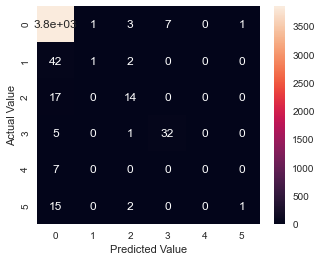

In [ ]:
cm = confusion_matrix(y_test, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# Multiclass Multinomial Logistic Regression Tuned Model


In [ ]:
model3 = LogisticRegressionCV(verbose=0,cv=5, random_state=1, max_iter=500,
                              class_weight={0: 0.2}, scoring='f1_macro', multi_class='multinomial')
model3 = model3.fit(X_train, y_train)
model3.score(X_train, y_train), model3.score(X_test, y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages

(0.5703057382837164, 0.5747511146358447)

In [ ]:
p = model3.predict(X_test)

Text(25.0, 0.5, 'Actual Value')

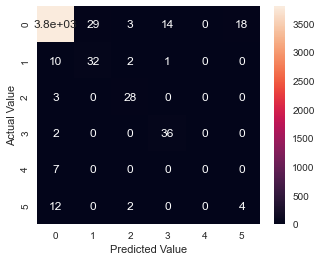

In [ ]:
cm = confusion_matrix(y_test, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

In [ ]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3861
           1       0.52      0.71      0.60        45
           2       0.80      0.90      0.85        31
           3       0.71      0.95      0.81        38
           4       0.00      0.00      0.00         7
           5       0.18      0.22      0.20        18

    accuracy                           0.97      4000
   macro avg       0.53      0.63      0.57      4000
weighted avg       0.98      0.97      0.97      4000



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# One-Versus-Rest (OVR) Multinomial Logistic Regression Base Model

In [ ]:
model_ovr = LogisticRegressionCV(verbose=0,cv=5, random_state=1,scoring='f1_macro', multi_class='ovr')
model_ovr = model_ovr.fit(X_train, y_train)
model_ovr.score(X_train, y_train), model_ovr.score(X_test, y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages

(0.4136128009136999, 0.4173005037392283)

In [ ]:
p = model_ovr.predict(X_test)

Text(25.0, 0.5, 'Actual Value')

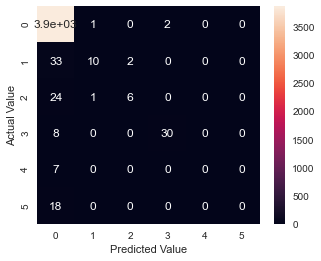

In [ ]:
cm = confusion_matrix(y_test, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

In [ ]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3861
           1       0.83      0.22      0.35        45
           2       0.75      0.19      0.31        31
           3       0.94      0.79      0.86        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        18

    accuracy                           0.98      4000
   macro avg       0.58      0.37      0.42      4000
weighted avg       0.97      0.98      0.97      4000



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# One-Versus-Rest (OVR) Multinomial Logistic Regression Tuned Model

In [ ]:
model_ovr = LogisticRegressionCV(verbose=0,cv=5, random_state=1, max_iter=200,
                              class_weight={0: 0.2}, scoring='f1_macro', multi_class='ovr')
model_ovr = model_ovr.fit(X_train, y_train)
model_ovr.score(X_train, y_train), model_ovr.score(X_test, y_test)

(0.5386163411845986, 0.5170484349238377)

In [ ]:
p = model_ovr.predict(X_test)

Text(25.0, 0.5, 'Actual Value')

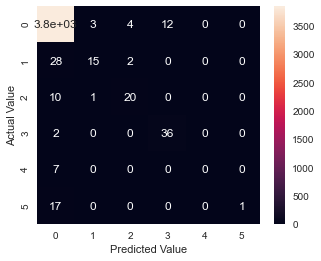

In [ ]:
cm = confusion_matrix(y_test, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

In [ ]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3861
           1       0.79      0.33      0.47        45
           2       0.77      0.65      0.70        31
           3       0.75      0.95      0.84        38
           4       0.00      0.00      0.00         7
           5       1.00      0.06      0.11        18

    accuracy                           0.98      4000
   macro avg       0.72      0.50      0.52      4000
weighted avg       0.98      0.98      0.97      4000



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# using model 3
compare = pd.DataFrame({'Predicted': p.transpose(),'Actual': y_test}, columns=['Predicted', 'Actual'])


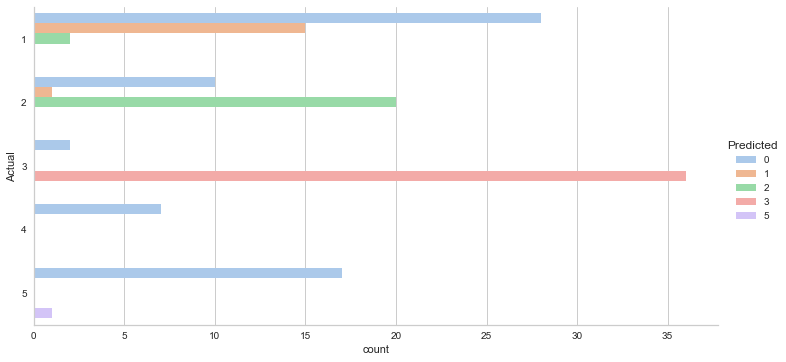

In [ ]:
sns.catplot(
    data=compare[compare['Actual']!=0], y="Actual", hue="Predicted", kind="count",palette="pastel", aspect=2)


In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

<ipython-input-69-a8fa972e7252>:11: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-69-a8fa972e7252>:19: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
for i in range (0,6): 
    print(f"Specificity for class {i}: {TNR[i]}")
    print("\n")

Specificity for class 0: 0.539568345323741


Specificity for class 1: 0.9989886219974715


Specificity for class 2: 0.99848828420257


Specificity for class 3: 0.9969712266532055


Specificity for class 4: 1.0


Specificity for class 5: 1.0




# Threshold Setting

In [ ]:
for i in range (0,6):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, p, [i], drop_intermediate=True)
    print(F"{i} class tpr: {tpr}")
    print(F"{i} class fpr: {fpr}")
    print(F"{i} class thresholds: {fpr-tpr}")

0 class tpr: [0.       0.       0.003108 0.004144 0.004921 1.      ]
0 class fpr: [0.         0.00719424 0.26618705 0.42446043 0.53956835 1.        ]
0 class thresholds: [0.         0.00719424 0.26307905 0.42031643 0.53464734 0.        ]
1 class tpr: [0.         0.         0.         0.04444444 0.37777778 1.        ]
1 class fpr: [0.00000000e+00 2.52844501e-04 1.23893805e-02 1.84576485e-02
 1.94690265e-02 1.00000000e+00]
1 class thresholds: [ 0.00000000e+00  2.52844501e-04  1.23893805e-02 -2.59867959e-02
 -3.58308751e-01  0.00000000e+00]
2 class tpr: [0.         0.         0.         0.64516129 0.67741935 1.        ]
2 class fpr: [0.00000000e+00 2.51952633e-04 1.23456790e-02 1.38573948e-02
 1.83925422e-02 1.00000000e+00]
2 class thresholds: [ 0.00000000e+00  2.51952633e-04  1.23456790e-02 -6.31303896e-01
 -6.59026813e-01  0.00000000e+00]
3 class tpr: [0.         0.         0.94736842 0.94736842 0.94736842 1.        ]
3 class fpr: [0.00000000e+00 2.52397779e-04 3.28117113e-03 9.84351338

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass pos_label=[0] as keyword args. From version 0.25 passing these as positional arguments will result in an error

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass pos_label=[1] as keyword args. From version 0.25 passing these as positional arguments will result in an error

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass pos_label=[2] as keyword args. From version 0.25 passing these as positional arguments will result in an error

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass pos_label=[3] as keyword args. From version 0.25 passing these as positional arguments will result in an error

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass pos_label=[4] as keyword args. From version 0.25 passing these as positi

In [ ]:
pred_proba_df = pd.DataFrame(model3.predict_proba(X_test))

In [ ]:
pred_proba_df

,0,1,2,3,4,5
0,0.992110,8.529543e-04,3.494592e-13,2.242662e-08,0.007037,1.199030e-08
1,0.978757,3.783875e-13,1.433020e-08,1.559108e-06,0.004541,1.669973e-02
2,0.982547,9.110060e-03,1.314703e-13,7.443959e-09,0.008343,7.068813e-09
3,0.991929,1.408734e-05,1.190369e-09,2.190447e-09,0.007985,7.120675e-05
4,0.997203,2.438654e-10,1.403679e-13,4.992863e-09,0.002797,9.089663e-08
...,...,...,...,...,...,...
3995,0.862597,5.595729e-06,7.427288e-05,6.753483e-08,0.008328,1.289954e-01
3996,0.990638,2.060933e-05,6.866625e-10,8.199301e-07,0.009339,1.270109e-06
3997,0.991381,3.031894e-04,1.910280e-09,5.025071e-06,0.008311,5.568985e-08
3998,0.988523,8.585656e-05,6.863219e-07,7.696804e-06,0.011325,5.758823e-05


In [ ]:
pred_proba_df['0'] = pred_proba_df.iloc[:,[0]].applymap(lambda x: 1 if x>0.73 else 0)

In [ ]:
pred_proba_df['1'] = pred_proba_df.iloc[:,[1]].applymap(lambda x: 1 if x>0.74 else 0)

In [ ]:
pred_proba_df['2'] = pred_proba_df.iloc[:,[2]].applymap(lambda x: 1 if x>0.86 else 0)

In [ ]:
pred_proba_df['3'] = pred_proba_df.iloc[:,[3]].applymap(lambda x: 1 if x>0.9 else 0)

In [ ]:
pred_proba_df['4'] = pred_proba_df.iloc[:,[4]].applymap(lambda x: 1 if x>0.1 else 0)

In [ ]:
pred_proba_df['5'] = pred_proba_df.iloc[:,[5]].applymap(lambda x: 1 if x>0.29 else 0)

In [ ]:
pred_proba_df.iloc[:,[6,7,8,9,10,11]].value_counts()

0  1  2  3  4  5
1  0  0  0  0  0    3677
0  0  0  0  0  0     199
               1      67
         1  0  0      32
   1  0  0  0  0      16
   0  1  0  0  0       9
dtype: int64

In [ ]:
pred_proba_df['sum'] = pred_proba_df.iloc[:,[6,7,8,9,10,11]].sum(axis=1)

In [ ]:
pred_proba_df

In [ ]:
pred_proba_df['decision'] = np.where(pred_proba_df['sum']==1, pred_proba_df[['1','2','3','4','5']].idxmax(axis=1), 'fill')

In [ ]:
pred_proba_df['decision'] = np.where(pred_proba_df['sum']<1, 'no_pred', pred_proba_df.iloc[:,[0,1,2,3,4,5]].idxmax(axis=1))



In [ ]:
pred_proba_df['decision'].value_counts()

0          3721
no_pred     199
3            32
5            22
1            16
2            10
Name: decision, dtype: int64

In [ ]:
p_removed = pred_proba_df[pred_proba_df['decision']!='no_pred']['decision']

In [ ]:
p_removed.value_counts()

0    3721
3      32
5      22
1      16
2      10
Name: decision, dtype: int64

In [ ]:
y_test_removed = y_test.copy()

In [ ]:
ind = pred_proba_df.loc[pred_proba_df.decision == 'no_pred'].index

In [ ]:
for i in ind:
    y_test_removed.drop(y_test.index[i], inplace=True)

In [ ]:
y_test_removed

5235    0
9404    0
4218    0
2984    0
8222    0
       ..
8252    0
6758    0
2710    0
7363    0
1733    0
Name: code, Length: 3801, dtype: int64

In [ ]:
p_removed = pd.to_numeric(y_test_removed) # was string because of no_pred label earlier

Text(25.0, 0.5, 'Actual Value')

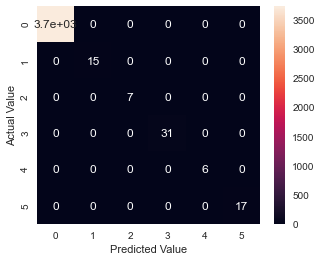

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(p_removed, y_test_removed)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# Feature Engineering

In [ ]:
def add_interactions(df):
    df['air_process_dif'] = df['Air_temperature_K']-df['Process_temperature_K']
    df['torque_x_rotational'] = df['Torque_Nm']*df['Rotational_speed_rpm']
    df['torque_x_Tool_wear_min'] = df['Torque_Nm']*df['Tool_wear_min']
    
    return df

In [ ]:
X_train_interaction = add_interactions(X_train.copy())

In [ ]:
X_test_interaction = add_interactions(X_test.copy())

## Multiclass Multinomial Logistic Regression Base Model With Interaction Terms

In [ ]:
model3 = LogisticRegressionCV(verbose=0,cv=5, random_state=1,
                              scoring='f1_macro')
model3 = model3.fit(X_train_interaction, y_train)
model3.score(X_train_interaction, y_train), model3.score(X_test_interaction, y_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

(0.24728487521617357, 0.23890239943897948)

In [ ]:
p= model3.predict(X_test_interaction)

In [ ]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3861
           1       0.00      0.00      0.00        45
           2       0.61      0.35      0.45        31
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        18

    accuracy                           0.97      4000
   macro avg       0.26      0.23      0.24      4000
weighted avg       0.94      0.97      0.95      4000



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Outlier Removal

In [ ]:
outliers_removed = pd.concat([X_train, y_train], axis=1)

In [ ]:
outliers_removed_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
outliers_list_index = [4153, 9576, 3829, 4078, 6091, 5400, 5401, 8846, 5309, 2270]

In [ ]:
def filter_m(df): 
    ind = df[(df['Rotational_speed_rpm']>=1895)&(df['Type_M']==1)&
                 (df['code']==0)].index
    
    return ind

In [ ]:
def filter_l(df): 
    ind = df[(df['Rotational_speed_rpm']>=1896)&(df['Type_L']==1)&
                     (df['code']==0)].index

    return ind

In [ ]:
def filter_h(df): 
    ind = df[(df['Rotational_speed_rpm']>=1906)&(df['Type_H']==1)&
                     (df['code']==0)].index

    return ind

In [ ]:
for i in filter_h(outliers_removed):
    outliers_removed.drop(i, inplace=True)


In [ ]:
for i in filter_l(outliers_removed):
    outliers_removed.drop(i, inplace=True)


In [ ]:
for i in filter_m(outliers_removed):
    outliers_removed.drop(i, inplace=True)


In [ ]:
for i in outliers_list_index:
    if i in outliers_removed:
        outliers_removed.drop(i, inplace=True)
        
    if i in outliers_removed_test:
        outliers_removed_test.drop(i, inplace=True)


In [ ]:
for i in filter_h(outliers_removed_test):
    outliers_removed_test.drop(i, inplace=True)


In [ ]:
for i in filter_l(outliers_removed_test):
    outliers_removed_test.drop(i, inplace=True)


In [ ]:
for i in filter_m(outliers_removed_test):
    outliers_removed_test.drop(i, inplace=True)


In [ ]:
outliers_removed.shape #0.04% removed

(5771, 9)

In [ ]:
outliers_removed_test.shape # 0.04% removed

(3845, 9)

In [ ]:
outliers_removed.columns

Index(['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm',
       'Torque_Nm', 'Tool_wear_min', 'Type_H', 'Type_L', 'Type_M', 'code'],
      dtype='object')

In [ ]:
X_train_removed = outliers_removed.iloc[:,[0,1,2,3,4,5,6,7]]
y_train_removed = outliers_removed.iloc[:,[8]]

In [ ]:
X_test_removed = outliers_removed_test.iloc[:,[0,1,2,3,4,5,6,7]]
y_test_removed = outliers_removed_test.iloc[:,[8]]

## Multiclass Multinomial Logistic Regression Base Model With Outlier Treatment

In [ ]:
model3 = LogisticRegressionCV(verbose=0,cv=5, random_state=1,
                              scoring='f1_macro')
model3 = model3.fit(X_train_removed, y_train_removed)
model3.score(X_train_removed, y_train_removed), model3.score(X_test_removed, y_test_removed)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations 

(0.40786138762255436, 0.38679776947262273)

In [ ]:
p = model3.predict(X_test_removed)

In [ ]:
print(classification_report(y_test_removed, p))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3706
           1       0.00      0.00      0.00        45
           2       0.65      0.35      0.46        31
           3       0.83      0.92      0.88        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        18

    accuracy                           0.97      3845
   macro avg       0.41      0.38      0.39      3845
weighted avg       0.96      0.97      0.96      3845



##  Multiclass Multinomial Logistic Regression Tuned Model With Outlier Treatment

In [ ]:
model3 = LogisticRegressionCV(verbose=0,cv=5, random_state=1, max_iter=500,
                              class_weight={0: 0.2}, scoring='f1_macro', multi_class='multinomial')
model3 = model3.fit(X_train_removed, y_train_removed)
model3.score(X_train_removed, y_train_removed), model3.score(X_test_removed, y_test_removed)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations 

(0.5812529434084436, 0.5780242100280617)

In [ ]:
p = model3.predict(X_test_removed)

In [ ]:
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3706
           1       0.63      0.73      0.68        45
           2       0.76      0.94      0.84        31
           3       0.72      1.00      0.84        38
           4       0.00      0.00      0.00         7
           5       0.10      0.17      0.12        18

    accuracy                           0.97      3845
   macro avg       0.53      0.64      0.58      3845
weighted avg       0.98      0.97      0.97      3845



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging


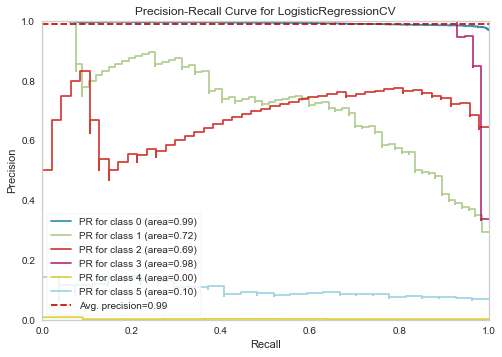

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegressionCV'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
viz = PrecisionRecallCurve(model3, per_class=True)
viz.fit(X_train_removed, y_train_removed)
viz.score(X_train_removed, y_train_removed)
viz.show()

Text(25.0, 0.5, 'Actual Value')

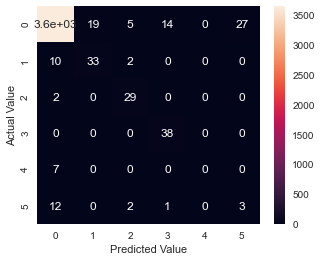

In [ ]:
cm = confusion_matrix(y_test_removed,p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

## Adding Interactions & Transforming

In [ ]:
X_removedO_interaction = add_interactions(X_train_removed.copy())
X_removedO_test_interaction = add_interactions(X_test_removed.copy())

In [ ]:
X_removedO_interaction.columns

Index(['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm',
       'Torque_Nm', 'Tool_wear_min', 'Type_H', 'Type_L', 'Type_M',
       'air_process_dif', 'torque_x_rotational', 'torque_x_Tool_wear_min'],
      dtype='object')

In [ ]:
transformer = RobustScaler().fit(X_removed_interaction.iloc[:,[0,1,2,3,4,8,9,10]])
transformed = X_removedO_interaction.copy()
transformed.iloc[:,[0,1,2,3,4,8,9,10]] = transformer.transform(X_removed_interaction.iloc[:,[0,1,2,3,4,8,9,10]])

In [ ]:
transformed_test = X_removed_test_interaction.copy()
transformed_test.iloc[:,[0,1,2,3,4,8,9,10]] = transformer.transform(transformed_test.iloc[:,[0,1,2,3,4,8,9,10]])

## Multiclass Multinomial Logistic Regression Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
model3 = LogisticRegressionCV(verbose=0,cv=5, random_state=1,
                              scoring='f1_macro')
model3 = model3.fit(transformed, y_train_removed)
model3.score(transformed, y_train_removed), model3.score(transformed_test, y_test_removed)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations 

(0.6147482180151441, 0.5663121548459894)

In [ ]:
p = model3.predict(transformed_test)
print(classification_report(y_test_removed, p))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3706
           1       0.87      0.60      0.71        45
           2       0.79      0.61      0.69        31
           3       0.83      1.00      0.90        38
           4       0.00      0.00      0.00         7
           5       0.50      0.06      0.10        18

    accuracy                           0.98      3845
   macro avg       0.66      0.54      0.57      3845
weighted avg       0.98      0.98      0.98      3845



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Multiclass Multinomial Logistic Regression Tuned Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
model3 = LogisticRegressionCV(verbose=0,cv=5, random_state=1, max_iter=500,
                              class_weight={0: 0.4}, scoring='f1_macro', multi_class='multinomial')
model3 = model3.fit(transformed, y_train_removed)
model3.score(transformed, y_train_removed), model3.score(transformed_test, y_test_removed)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations 

(0.6109770209925669, 0.5981589473206622)

In [ ]:
p = model3.predict(transformed_test)
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3706
           1       0.69      0.73      0.71        45
           2       0.80      0.77      0.79        31
           3       0.86      1.00      0.93        38
           4       0.00      0.00      0.00         7
           5       0.40      0.11      0.17        18

    accuracy                           0.98      3845
   macro avg       0.62      0.60      0.60      3845
weighted avg       0.98      0.98      0.98      3845



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


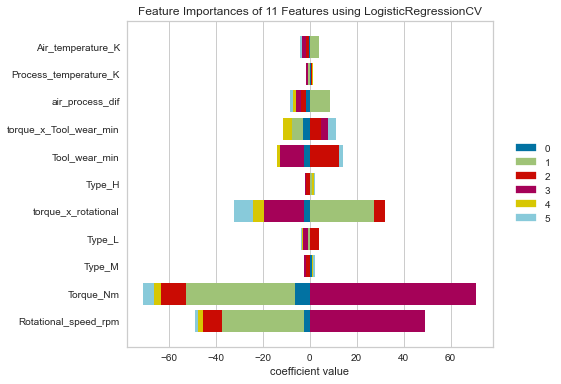

<AxesSubplot:title={'center':'Feature Importances of 11 Features using LogisticRegressionCV'}, xlabel='coefficient value'>

In [ ]:
viz = FeatureImportances(model3, relative=False, stack=True)
viz.fit(transformed, y_train_removed)
viz.show()

# One-Versus-Rest (OVR) Multinomial Logistic Regression Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
model_ovr = LogisticRegressionCV(verbose=0,cv=5, random_state=1,scoring='f1_macro', multi_class='ovr')
model_ovr = model_ovr.fit(transformed, y_train_removed)
model_ovr.score(transformed, y_train_removed), model_ovr.score(transformed_test, y_test_removed)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations 

(0.5069866959727812, 0.445622488404092)

In [ ]:
p=model_ovr.predict(transformed_test)
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3706
           1       0.92      0.24      0.39        45
           2       0.78      0.23      0.35        31
           3       0.93      0.97      0.95        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        18

    accuracy                           0.98      3845
   macro avg       0.60      0.41      0.45      3845
weighted avg       0.97      0.98      0.97      3845



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# One-Versus-Rest (OVR) Multinomial Logistic Regression Tuned Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
model_ovr = LogisticRegressionCV(verbose=0,cv=5, random_state=1, max_iter=200,
                              class_weight={0: 0.1}, scoring='f1_macro', multi_class='ovr')
model_ovr = model_ovr.fit(transformed, y_train_removed)
model_ovr.score(transformed, y_train_removed), model_ovr.score(transformed_test, y_test_removed)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(0.5953097731013932, 0.5787610449849538)

In [ ]:
p=model_ovr.predict(transformed_test)
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3706
           1       0.49      0.80      0.61        45
           2       0.71      0.81      0.76        31
           3       0.81      1.00      0.89        38
           4       0.00      0.00      0.00         7
           5       0.24      0.22      0.23        18

    accuracy                           0.97      3845
   macro avg       0.54      0.64      0.58      3845
weighted avg       0.98      0.97      0.97      3845



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Boosting

# XGBoost Base Model

In [ ]:
xgb_cl = xgb.XGBClassifier(eval_metric='aucpr')

In [ ]:
xgb_cl.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
p = xgb_cl.predict(X_test)
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3861
           1       0.95      0.82      0.88        45
           2       0.76      0.52      0.62        31
           3       0.84      0.84      0.84        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        18

    accuracy                           0.98      4000
   macro avg       0.59      0.53      0.56      4000
weighted avg       0.98      0.98      0.98      4000



In [ ]:
print(f"Test: {f1_score(y_test,p, average='macro')}")
print(f"Train: {f1_score(y_train,p_fit, average='macro')}")

Test: 0.5550967369381977
Train: 1.0


Text(25.0, 0.5, 'Actual Value')

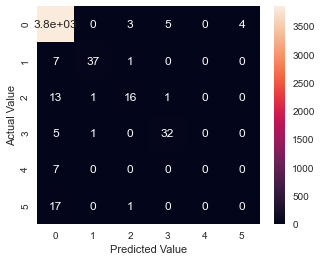

In [ ]:
cm = confusion_matrix(y_test, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# XGBoost Tuned Model

In [ ]:
param_grid = {
    "disable_default_eval_metric":[True],
    "learning_rate": [0, 0.01, 0.05, 0.1],
    "gamma": [1,5,10],
    "subsample": [1],
    "interaction_constraints": [[['Air_temperature_K', 'Process_temperature_K'], ['Rotational_speed_rpm', 'Torque_Nm'],
                                ['Torque_Nm','Tool_wear_min']]]
}

xgb_cl2 = xgb.XGBClassifier(objective="multi:softmax")
grid_cv =GridSearchCV(xgb_cl2, param_grid, n_jobs=-1, cv=3, scoring='f1_macro')
_ = grid_cv.fit(X_train, y_train)
print(f"best score: {grid_cv.best_score_}")
print(f"best parameters: {grid_cv.best_params_}")

best score: 0.4983973193754439
best parameters: {'disable_default_eval_metric': True, 'gamma': 1, 'interaction_constraints': [['Air_temperature_K', 'Process_temperature_K'], ['Rotational_speed_rpm', 'Torque_Nm'], ['Torque_Nm', 'Tool_wear_min']], 'learning_rate': 0.1, 'subsample': 1}


In [ ]:
final_cl = xgb.XGBClassifier(**grid_cv.best_params_, objective="multi:softmax", num_class=6)

In [ ]:
model_final = final_cl.fit(X_train, y_train)

In [ ]:
p = model_final.predict(X_test)

In [ ]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3861
           1       1.00      0.78      0.88        45
           2       0.74      0.55      0.63        31
           3       0.92      0.89      0.91        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        18

    accuracy                           0.99      4000
   macro avg       0.61      0.54      0.57      4000
weighted avg       0.98      0.99      0.98      4000



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
print(f"Test: {f1_score(y_test,p, average='macro')}")

Test: 0.5673904849565851


## XGBoost With Outlier Treatment, Feature Scaling, and Monotone Transformations

In [ ]:
model = xgb_cl.fit(transformed, y_train_removed)

In [ ]:
p = model.predict(transformed_test)
p_fit = model.predict(transformed)
f1_score(y_train_removed, p_fit, average='macro')

1.0

In [ ]:
print(classification_report(y_test_removed, p))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3706
           1       0.98      0.89      0.93        45
           2       0.93      0.84      0.88        31
           3       0.95      1.00      0.97        38
           4       1.00      0.14      0.25         7
           5       0.00      0.00      0.00        18

    accuracy                           0.99      3845
   macro avg       0.81      0.64      0.67      3845
weighted avg       0.99      0.99      0.99      3845



Text(25.0, 0.5, 'Actual Value')

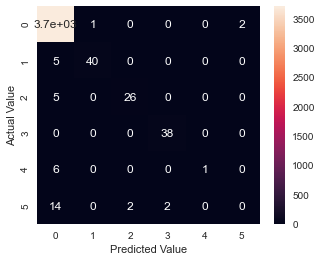

In [ ]:
cm = confusion_matrix(y_test_removed, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

In [ ]:
param_grid = {
    "disable_default_eval_metric":[True],
    "learning_rate": [0, 0.01, 0.05, 0.1],
    "gamma": [1,5,10],
    "subsample": [1],
    "interaction_constraints": [[['Air_temperature_K', 'Process_temperature_K'], ['Rotational_speed_rpm', 'Torque_Nm'],
                                ['Torque_Nm','Tool_wear_min']]]
}

xgb_cl2 = xgb.XGBClassifier(objective="multi:softmax")
grid_cv =GridSearchCV(xgb_cl2, param_grid, n_jobs=-1, cv=3, scoring='f1_macro')
_ = grid_cv.fit(transformed, y_train_removed)
print(f"best score: {grid_cv.best_score_}")
print(f"best parameters: {grid_cv.best_params_}")

best score: 0.6134237687165539
best parameters: {'disable_default_eval_metric': True, 'gamma': 5, 'interaction_constraints': [['Air_temperature_K', 'Process_temperature_K'], ['Rotational_speed_rpm', 'Torque_Nm'], ['Torque_Nm', 'Tool_wear_min']], 'learning_rate': 0.1, 'subsample': 1}


In [ ]:
final_cl = xgb.XGBClassifier(**grid_cv.best_params_, objective="multi:softmax", num_class=6)

In [ ]:
model_final = final_cl.fit(transformed, y_train_removed)

In [ ]:
p = model_final.predict(transformed_test)

In [ ]:
print(classification_report(y_test_removed, p))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3706
           1       0.98      0.89      0.93        45
           2       0.93      0.84      0.88        31
           3       1.00      1.00      1.00        38
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        18

    accuracy                           0.99      3845
   macro avg       0.65      0.62      0.63      3845
weighted avg       0.98      0.99      0.99      3845



In [ ]:
explainer = shap.TreeExplainer(model_final) # we only need to pass our  fitted model to tree explainer. 
                                    #No background dataset in 'data' argument required for tree models as it
                                    #is automatically received through the model tree object.

# finding out the shap values using the explainer
shap_values = explainer.shap_values(transformed)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
le_name_mapping

{'Heat Dissipation Failure': 1,
 'No Failure': 0,
 'Overstrain Failure': 2,
 'Power Failure': 3,
 'Random Failures': 4,
 'Tool Wear Failure': 5}

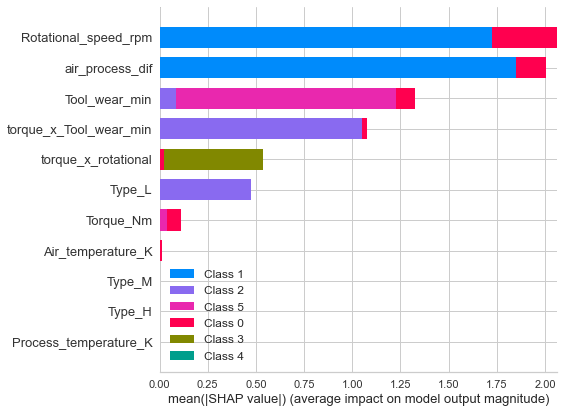

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, transformed_test)

# tool and torque yes
# power failure yes 
# heat failure yes 
# class 5 tool wear yes 
# class 4 is not using anything which makes sense because its random

Text(25.0, 0.5, 'Actual Value')

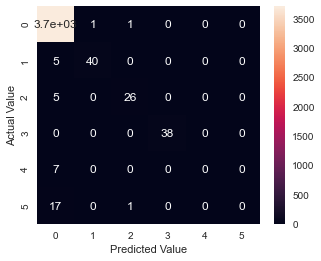

In [ ]:
cm = confusion_matrix(y_test_removed, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

In [ ]:
# 5 is not occuring frequently. Maybe we just need more data.

# SMOTEBoost Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
from imbalanced_algorithms.smote import SMOTEBoost

In [ ]:
smotecl = SMOTEBoost(random_state=0)

In [ ]:
model = smotecl.fit(transformed, y_train_removed, minority_target=[1,2,3,4,5])
p = model.predict(transformed_test)
f1_score(y_test_removed, p, average='macro')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.33109277252761876

#  SMOTENC Sampling and XGBoost Tuned Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
oversampled_data = SMOTENC(sampling_strategy='not majority', categorical_features=[5,6,7])
X_over, y_over = oversampled_data.fit_resample(transformed,y_train_removed)

In [ ]:
param_grid = {
    "disable_default_eval_metric":[True],
    "learning_rate": [0, 0.01, 0.05, 0.1],
    "gamma": [1,5,10],
    "subsample": [1],
    "interaction_constraints": [[['Air_temperature_K', 'Process_temperature_K'], ['Rotational_speed_rpm', 'Torque_Nm'],
                                ['Torque_Nm','Tool_wear_min']]]
}

xgb_cl2 = xgb.XGBClassifier(objective="multi:softmax", num_class=6)
grid_cv =GridSearchCV(xgb_cl2, param_grid, n_jobs=-1, cv=3, scoring='f1_macro')
_ = grid_cv.fit(X_over, y_over)
print(f"best score: {grid_cv.best_score_}")
print(f"best parameters: {grid_cv.best_params_}")

best score: 0.9589260865057524
best parameters: {'disable_default_eval_metric': True, 'gamma': 1, 'interaction_constraints': [['Air_temperature_K', 'Process_temperature_K'], ['Rotational_speed_rpm', 'Torque_Nm'], ['Torque_Nm', 'Tool_wear_min']], 'learning_rate': 0.1, 'subsample': 1}


In [ ]:
final_cl = xgb.XGBClassifier(**grid_cv.best_params_, objective="multi:softmax", num_class=6)

In [ ]:
model_final = final_cl.fit()

In [ ]:
p = model_final.predict(transformed_test)

In [ ]:
print(f"Test: {f1_score(y_test_removed,p, average='macro')}")

Test: 0.6955082480650664


In [ ]:
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3861
           1       1.00      0.96      0.98        45
           2       0.94      0.97      0.95        31
           3       0.95      0.97      0.96        38
           4       0.00      0.00      0.00         7
           5       1.00      0.17      0.29        18

    accuracy                           0.99      4000
   macro avg       0.81      0.68      0.70      4000
weighted avg       0.99      0.99      0.99      4000



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Text(25.0, 0.5, 'Actual Value')

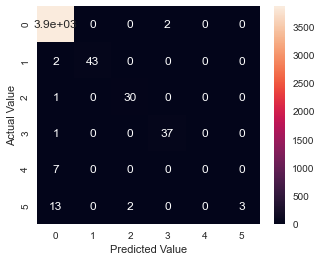

In [ ]:
cm = confusion_matrix(y_test_removed,p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging


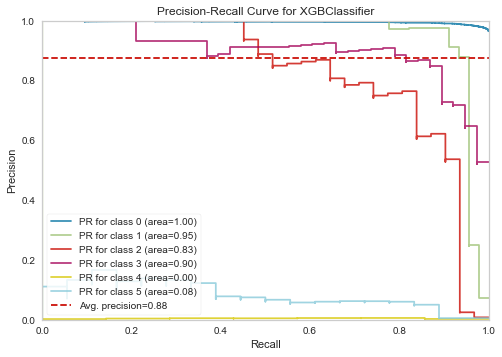

TypeError: __init__() missing 1 required positional argument: 'estimator'

In [ ]:
viz = PrecisionRecallCurve(model_final, per_class=True, num_class=6,classes=[0,1,2,3,4,5])
viz.fit(X_over, y_over)
viz.score(transformed_test, y_test_removed)
viz.show()

# SMOTENC Sampling and AdaBoost Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
adacl = AdaBoostClassifier(random_state=0)

In [ ]:
adacl.fit(X_over, y_over)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AdaBoostClassifier(random_state=0)

In [ ]:
p2 = adacl.predict(transformed_test)

In [ ]:
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3706
           1       0.97      0.84      0.90        45
           2       0.90      0.87      0.89        31
           3       1.00      1.00      1.00        38
           4       0.00      0.00      0.00         7
           5       1.00      0.11      0.20        18

    accuracy                           0.99      3845
   macro avg       0.81      0.64      0.66      3845
weighted avg       0.99      0.99      0.99      3845



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Text(25.0, 0.5, 'Actual Value')

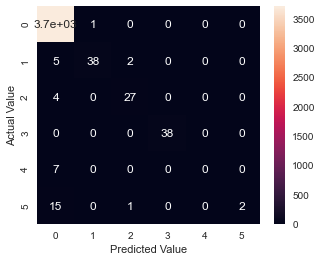

In [ ]:
cm = confusion_matrix(y_test_removed,p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# ADASYN Sampling and XGBoost Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
oversampled_data = ADASYN()
X_over_a, y_over_a = oversampled_data.fit_resample(transformed, y_train_removed)

In [ ]:
y_over_a.value_counts()

code
5       5574
4       5566
3       5565
1       5564
0       5562
2       5560
dtype: int64

In [ ]:
model = xgb.XGBClassifier(objective="multi:softmax", eval_metric='aucpr', num_class=6)

In [ ]:
model.fit(X_over_a, y_over_a)
p = model.predict(transformed_test)

In [ ]:
print(classification_report(y_test_removed, p))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3706
           1       0.95      0.91      0.93        45
           2       0.96      0.71      0.81        31
           3       0.95      1.00      0.97        38
           4       0.00      0.00      0.00         7
           5       0.04      0.06      0.05        18

    accuracy                           0.98      3845
   macro avg       0.65      0.61      0.63      3845
weighted avg       0.98      0.98      0.98      3845



Text(25.0, 0.5, 'Actual Value')

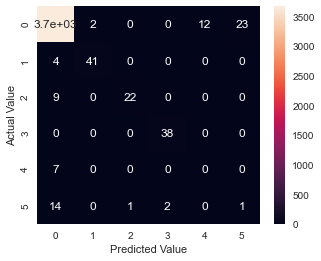

In [ ]:
cm = confusion_matrix(y_test_removed, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

#  BorderlineSMOTE Sampling and XGBoost Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
oversampled_data = BorderlineSMOTE(random_state=0)
X_over_b, y_over_b = oversampled_data.fit_resample(transformed, y_train_removed)


In [ ]:
y_over_b.value_counts()

code
5       5562
3       5562
2       5562
1       5562
0       5562
4         11
dtype: int64

In [ ]:
model = xgb.XGBClassifier(objective="multi:softmax", eval_metric='aucpr', num_class=6)

In [ ]:
model.fit(X_over_b, y_over_b)
p = model.predict(transformed_test)
p2 = model.predict(transformed)

In [ ]:
f1_score(y_train_removed,p2, average='macro')

1.0

In [ ]:
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3706
           1       0.95      0.89      0.92        45
           2       0.85      0.74      0.79        31
           3       0.95      1.00      0.97        38
           4       0.00      0.00      0.00         7
           5       0.03      0.06      0.04        18

    accuracy                           0.98      3845
   macro avg       0.63      0.61      0.62      3845
weighted avg       0.98      0.98      0.98      3845



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Text(25.0, 0.5, 'Actual Value')

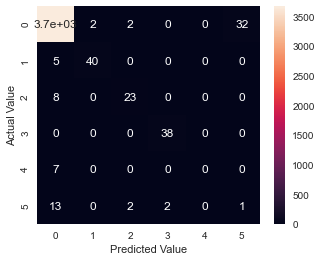

In [ ]:
cm = confusion_matrix(y_test_removed, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging


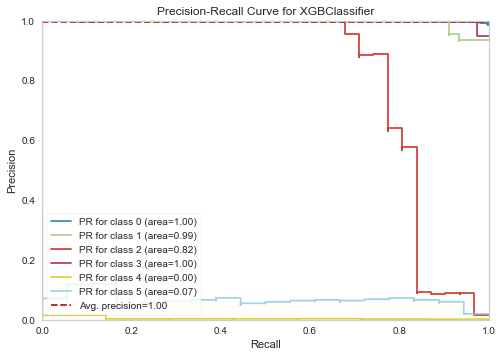

<AxesSubplot:title={'center':'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
viz = PrecisionRecallCurve(model, per_class=True, num_class=6,classes=[0,1,2,3,4,5])
viz.fit(X_over_b, y_over_b)
viz.score(transformed_test, y_test_removed)
viz.show()


# RandomOverSampler Sampling and XGBoost Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
oversampled_data = RandomOverSampler(random_state=0)
X_over_R, y_over_R = oversampled_data.fit_resample(transformed, y_train_removed)

In [ ]:
y_over_R.value_counts()

code
5       5562
4       5562
3       5562
2       5562
1       5562
0       5562
dtype: int64

In [ ]:
model = xgb.XGBClassifier(objective="multi:softmax", eval_metric='aucpr', num_class=6)
model.fit(X_over_R, y_over_R)
p = model.predict(transformed_test)
p2 = model.predict(transformed)

In [ ]:
f1_score(y_train_removed,p2,average='macro')

1.0

In [ ]:
print(classification_report(y_test_removed,p))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3706
           1       0.95      0.91      0.93        45
           2       0.90      0.84      0.87        31
           3       0.95      1.00      0.97        38
           4       1.00      0.14      0.25         7
           5       0.00      0.00      0.00        18

    accuracy                           0.99      3845
   macro avg       0.80      0.65      0.67      3845
weighted avg       0.99      0.99      0.99      3845



Text(25.0, 0.5, 'Actual Value')

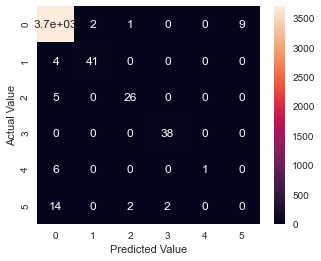

In [ ]:
cm = confusion_matrix(y_test_removed, p)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging


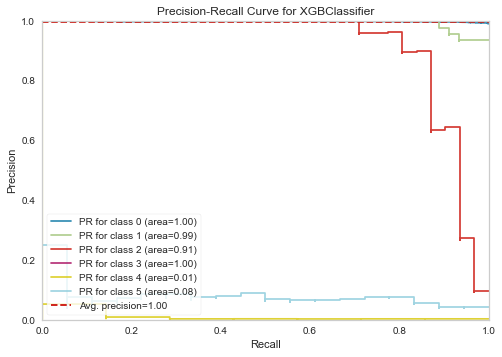

<AxesSubplot:title={'center':'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
viz = PrecisionRecallCurve(model, per_class=True, num_class=6,classes=[0,1,2,3,4,5])
viz.fit(X_over_R, y_over_R)
viz.score(transformed_test, y_test_removed)
viz.show()


# Cluster Centroids Sampling and XGBoost Base Model with Outlier Treatment, Feature Scaling and Monotone Transformations

In [ ]:
cc = ClusterCentroids(random_state=0, sampling_strategy='majority')

In [ ]:
X_clust, y_clust = cc.fit_resample(transformed, y_train_removed)

In [ ]:
y_clust.value_counts()

code
1       67
3       57
2       47
5       27
4       11
0       11
dtype: int64

In [ ]:
model = xgb.XGBClassifier(objective="multi:softmax", eval_metric='aucpr',num_class=6)
model.fit(X_clust, y_clust)
p = model.predict(transformed_test)
p2 = model.predict(transformed)

In [ ]:
f1_score(y_train_removed,p2, average='macro')

0.2871719234055447

In [ ]:
print(classification_report(y_test_removed,p))
# it's actually not bad, but class 0 is predicted terribly 

              precision    recall  f1-score   support

           0       1.00      0.02      0.04      3706
           1       0.20      1.00      0.34        45
           2       0.78      0.94      0.85        31
           3       0.27      1.00      0.42        38
           4       0.00      1.00      0.00         7
           5       0.03      0.72      0.06        18

    accuracy                           0.05      3845
   macro avg       0.38      0.78      0.29      3845
weighted avg       0.98      0.05      0.06      3845



# Clustering 

In [ ]:
kmeans = KMeans(
init="random",
n_clusters=6,
n_init=10,
max_iter=300,
random_state=0
)

In [ ]:
transformed_concat = pd.concat([transformed.copy(), transformed_test.copy()])

In [ ]:
kmeans.fit(transformed_concat)

KMeans(init='random', n_clusters=6, random_state=0)

In [ ]:
transformed_concat['cluster'] = kmeans.labels_

In [ ]:
transformed_concat['code'] = pd.concat([y_train_removed.copy(), y_test_removed.copy()])

In [ ]:
def plot3d(x, y, z):
    fig = px.scatter_3d(transformed_concat, x=x, y=y, z=z,
              color='cluster', size='code', size_max=25, opacity=0.65, height=700, 
                    title="hi")
    
    return fig

In [ ]:
ipywidgets.interact(plot3d, x=variables[:-1], 
                    y = variables[:-1],
                    z = variables[:-1])

interactive(children=(Dropdown(description='x', options=('Air_temperature_K', 'Process_temperature_K', 'Rotati…

<function __main__.plot3d(x, y, z)>